In [1]:
!pip install pandas numpy nltk scikit-learn


Defaulting to user installation because normal site-packages is not writeable
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached scipy-1.15.3-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl.metadata (17 kB)
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.0 MB 3.1 MB/s eta 0:00:04
   ---- ----------------------------------- 1.3/11.0 MB 3.8 MB/s eta 0:00:03
   ------ --------------------------------- 1.8/11.0 MB 3.5 MB/s eta 0:00:03
   --------- ------------------------------ 2.6/11.0 MB 3.3 MB/s eta 0:00:03
   ----------- ---------------------------- 3.1/11.0 MB 3.4 MB/s eta 0:00:03
   ------------- -------------------------- 3.7/11.0 MB 3.2 MB/s eta 0:00:03
   --------------- ------------------------ 4.2/11.0 MB 3.0 MB/s eta 0:00:03
   ----------------- ---------------------- 4.7/11.0 MB 3.0 MB/s eta 0:00:03
   ------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91784\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
df = pd.read_csv("SMSSpamCollection", sep='\t', header=None, names=["label", "text"])

def preprocess(text):
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    words = text.split()
    stop_words = set(stopwords.words("english"))
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

df['clean_text'] = df['text'].apply(preprocess)
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})
df.head()


,label,text,clean_text,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...,0
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...,1
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think goes usf lives around though,0


In [13]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['label_num'], test_size=0.2, random_state=42)


In [15]:
vectorizers = {
    "CountVectorizer": CountVectorizer(),
    "TfidfVectorizer": TfidfVectorizer()
}

models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

results = {}

for vect_name, vectorizer in vectorizers.items():
    X_train_vect = vectorizer.fit_transform(X_train)
    X_test_vect = vectorizer.transform(X_test)

    for model_name, model in models.items():
        model.fit(X_train_vect, y_train)
        y_pred = model.predict(X_test_vect)
        y_proba = model.predict_proba(X_test_vect)[:, 1]

        print(f"\n===== {model_name} with {vect_name} =====")
        print(confusion_matrix(y_test, y_pred))
        print(classification_report(y_test, y_pred))

        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)

        results[f"{model_name} ({vect_name})"] = (fpr, tpr, auc)

        if model_name == "Logistic Regression":
            top_features = np.argsort(model.coef_[0])[-10:]
            print("Top Spam Predictive Words:")
            print(np.array(vectorizer.get_feature_names_out())[top_features])



===== Naive Bayes with CountVectorizer =====
[[960   6]
 [ 11 138]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.96      0.93      0.94       149

    accuracy                           0.98      1115
   macro avg       0.97      0.96      0.97      1115
weighted avg       0.98      0.98      0.98      1115


===== Logistic Regression with CountVectorizer =====
[[966   0]
 [ 17 132]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       1.00      0.89      0.94       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.97      1115
weighted avg       0.99      0.98      0.98      1115

Top Spam Predictive Words:
['reply' 'mobile' 'service' 'new' 'stop' 'ringtone' 'call' 'text' 'claim'
 'txt']

===== Naive Bayes with TfidfVectorizer =====
[[966   0]
 [ 32 117]]
              precisio

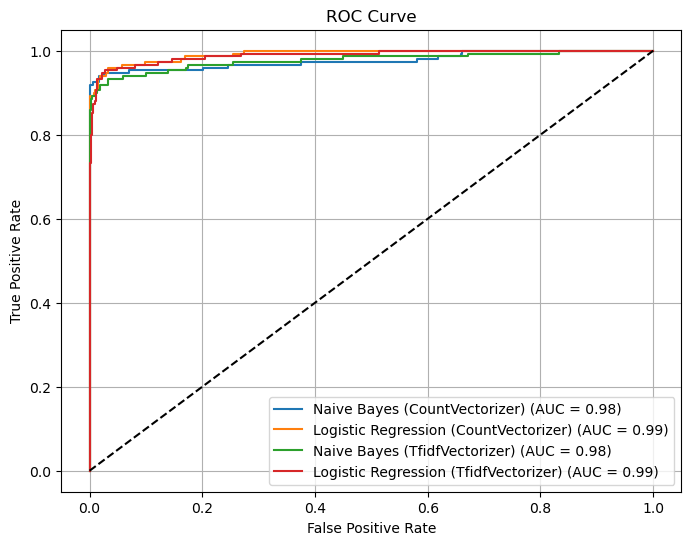

In [17]:
plt.figure(figsize=(8, 6))
for label, (fpr, tpr, auc) in results.items():
    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


In [19]:
import joblib

joblib.dump(model, "spam_model.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")


['vectorizer.pkl']